# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [2]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import warnings
import sys
sys.setrecursionlimit(10000)

# Data manipulation
import numpy as np
from scipy.special import erf
from scipy.integrate import quad, solve_ivp
import scipy.stats as stats
from scipy.signal import savgol_filter
from scipy.spatial import ConvexHull

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
from dyn_cond_fig_functions import *

# Clustering stuff
from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN, OPTICS
from itertools import cycle
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# plt.cm.tab20.colors

# From alens_analysis.py
import alens_analysis as aa
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
from alens_analysis import cluster_analysis as cla

from alens_analysis.colormaps import register_cmaps

# Locations
ws_path = Path('/home/alamson/DATA/Chromatin/')
mnt_path = Path.home() / 'projects/DATA/Chromatin/'
ceph_path = Path.home() / 'ceph/DATA/Chromatin/'

cuda


### Style settings

In [3]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)

colors = cycle(mcolors.XKCD_COLORS.keys())

register_cmaps()
plt.rcParams['image.cmap'] = 'YlOrRd'
        

In [4]:
cluster_similarity_threshold = .4 
nskip = 10 # Time snapshot skips for cluster finding. = 10 secs
vmax = 40 # Max colorbar value in kymographs
tree_length = 30 # min length of a cluster tree in time snapshots. = 15 sec

# Figure 6

## Snapshots of the simulation

In [4]:
!pvpython /mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/pv_snapshot_chromatin.py /mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/equilibration/24-04-12_aLc1_scan.48_line1600_Pin5um_2xKe30_2patch_sep100/simulations/s1/

!cp /mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/equilibration/24-04-12_aLc1_scan.48_line1600_Pin5um_2xKe30_2patch_sep100/simulations/s1/snapshot_chromatin_last.png Figure6/two_patch_snapshot.png

Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


Final snapshot of the baseline simulation at 3um separation and Ke=100.

<img width="50%" src="Figure6/two_patch_snapshot.png?raw=true"></img>


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


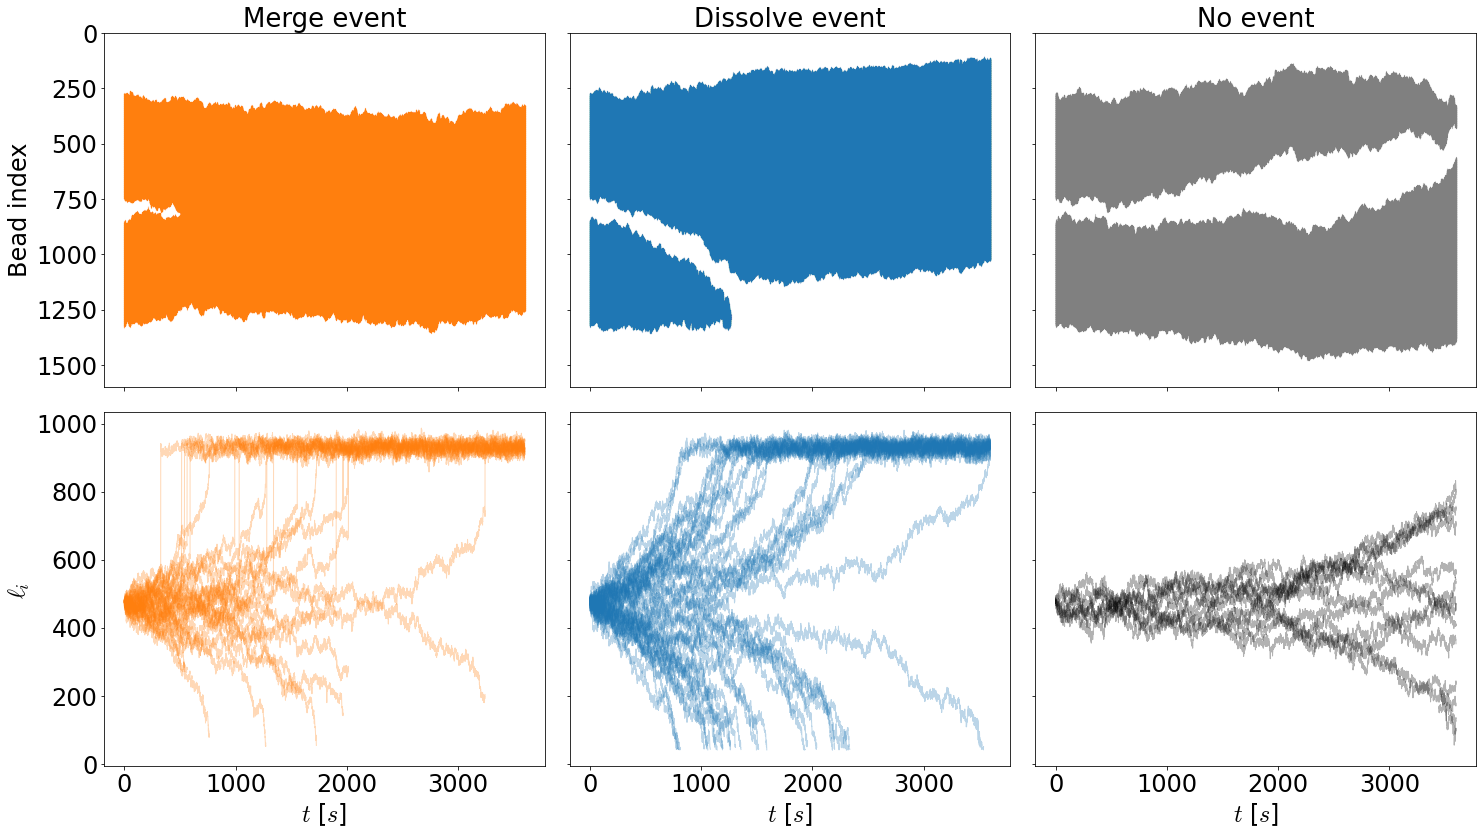

In [4]:
h5_contact_file = ceph_path / "DynCondPaper/24-04-15_aLc1_scan.48_line1600_Pin5um_2xKe30_ks100_2patch_sep100_equil/simulations/s27/analysis/cluster_analysis.h5"

fig, axarr = plt.subplots(2,3, figsize=(21, 12), sharex=True, sharey='row')
plot_params = {"linewidth": 1, "markersize": .5, "marker":'', "alpha":0.3, "linestyle":'-'}

_ = axarr[0,0].set_ylim(0, 1600)
large_tree_length = 100

## Upper row
with h5py.File(h5_contact_file, 'r') as h5_data:
    cluster_grp = h5_data['clusters']
    time_arr = h5_data['time'][...]
    time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
    clusters = []
    for tg in time_grp_list:
        clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]

    # Cluster tree
    root_clusters = cla.find_descendants(clusters, thresh=cluster_similarity_threshold, nskip=nskip)

    trees = []
    tree_id_gen = aa.helpers.gen_id()
    for root in root_clusters:
        tree = cla.ClusterTree(next(tree_id_gen))
        tree.add_recursive(root)
        trees += [tree]

    # Graph all clusters
    for tree in trees:
        if len(tree.clusters) < large_tree_length:
            continue
        for clust in tree.clusters:
            _ = axarr[0,0].plot([clust.time]*len(clust.part_ids), clust.part_ids, color = 'C1', markersize= .1, marker='.', linestyle='None')
    _ = axarr[0,0].set_title('Merge event', fontsize=26)

h5_contact_file = ceph_path / "DynCondPaper/24-04-15_aLc1_scan.48_line1600_Pin5um_2xKe30_ks100_2patch_sep100_equil/simulations/s3/analysis/cluster_analysis.h5"
with h5py.File(h5_contact_file, 'r') as h5_data:
    cluster_grp = h5_data['clusters']
    time_arr = h5_data['time'][...]
    time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
    clusters = []
    for tg in time_grp_list:
        clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]

    # Cluster tree
    root_clusters = cla.find_descendants(clusters, thresh=cluster_similarity_threshold, nskip=nskip)

    trees = []
    tree_id_gen = aa.helpers.gen_id()
    for root in root_clusters:
        tree = cla.ClusterTree(next(tree_id_gen))
        tree.add_recursive(root)
        trees += [tree]

    # Graph all clusters
    for tree in trees:
        if len(tree.clusters) < large_tree_length:
            continue
        for clust in tree.clusters:
            _ = axarr[0,1].plot([clust.time]*len(clust.part_ids), clust.part_ids, color = 'C0', markersize= .1, marker='.', linestyle='None')
    _ = axarr[0,1].set_title('Dissolve event', fontsize=26)

h5_contact_file = ceph_path / "DynCondPaper/24-04-15_aLc1_scan.48_line1600_Pin5um_2xKe30_ks100_2patch_sep100_equil/simulations/s25/analysis/cluster_analysis.h5"

with h5py.File(h5_contact_file, 'r') as h5_data:
    cluster_grp = h5_data['clusters']
    time_arr = h5_data['time'][...]
    time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
    clusters = []
    for tg in time_grp_list:
        clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]

    # Cluster tree
    root_clusters = cla.find_descendants(clusters, thresh=cluster_similarity_threshold, nskip=nskip)

    trees = []
    tree_id_gen = aa.helpers.gen_id()
    for root in root_clusters:
        tree = cla.ClusterTree(next(tree_id_gen))
        tree.add_recursive(root)
        trees += [tree]

    # Graph all clusters
    for tree in trees:
        if len(tree.clusters) < large_tree_length:
            continue
        for clust in tree.clusters:
            _ = axarr[0,2].plot([clust.time]*len(clust.part_ids), clust.part_ids, color = 'grey', markersize= .1, marker='.', linestyle='None')
    _ = axarr[0,2].set_title('No event', fontsize=26)

_ = axarr[0,0].set_ylabel('Bead index')
_ = axarr[0,0].invert_yaxis()


## Lower row
with h5py.File("Figure4/fig4_cluster_data.h5", 'r') as h5_graph:
    for name, d_set in h5_graph['merge'].items():
        condition = d_set[:,1] > 40 
        _ = axarr[1,0].plot(d_set[condition,0], d_set[condition,1], color='tab:orange', **plot_params)

    for name, d_set in h5_graph['dissolve'].items():
        condition = d_set[:,1] > 40 
        _ = axarr[1,1].plot(d_set[condition,0], d_set[condition,1], color='tab:blue', **plot_params)

    for name, d_set in h5_graph['nothing'].items():
        condition = d_set[:,1] > 40 
        _ = axarr[1,2].plot(d_set[condition,0], d_set[condition,1], color='k', **plot_params)

_ = axarr[1,0].set_ylabel('$\ell_i$ ' )
for ax in axarr[1]:
    _ = ax.set_xlabel('$t$ [$s$]')


fig.tight_layout()

fig.savefig("Figure6/fig6_merge_dissolve_no_event_kymos.png", dpi=600,bbox_inches='tight')



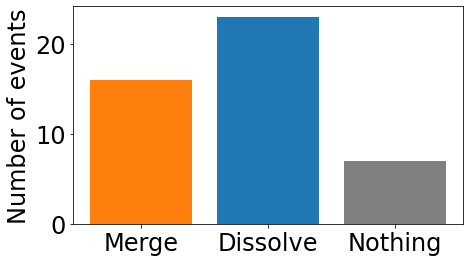

In [82]:
# Bar graph of merge events vs dissolve events vs nothing events
fig, ax = plt.subplots(1,1, figsize=(7, 4))
with h5py.File("Figure4/fig4_cluster_data.h5", 'r') as h5_graph:
    merge_life_times = h5_graph['merge'].attrs['merge_times']
    dissolve_life_times = h5_graph['dissolve'].attrs['dissolve_times']
    nothing_events = h5_graph['nothing'].attrs['nothing_events']
    _ = ax.bar(['Merge', 'Dissolve', 'Nothing'], [len(merge_life_times), len(dissolve_life_times), nothing_events], color=['tab:orange', 'tab:blue', 'grey'])
    _ = ax.set_ylabel('Number of events')
fig.savefig("Figure4/merge_dissolve_no_event_count.png", dpi=600,bbox_inches='tight')

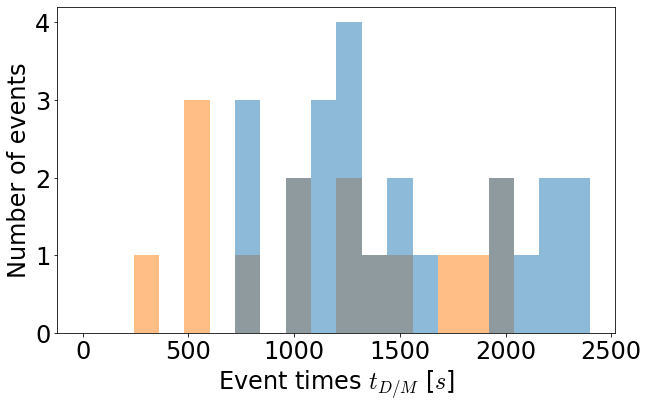

In [83]:
# Histogram of all events
fig, ax = plt.subplots(1,1, figsize=(10, 6))
_ = ax.hist(merge_life_times, bins=20, color='tab:orange', alpha=.5, label='Merge', range=(0, 2400))
_ = ax.hist(dissolve_life_times, bins=20, color='tab:blue', alpha=.5, label='Dissolve',range=(0, 2400))
_ = ax.set_xlabel('Event times $t_{D/M}$ [$s$]')
_ = ax.set_ylabel('Number of events')

7201


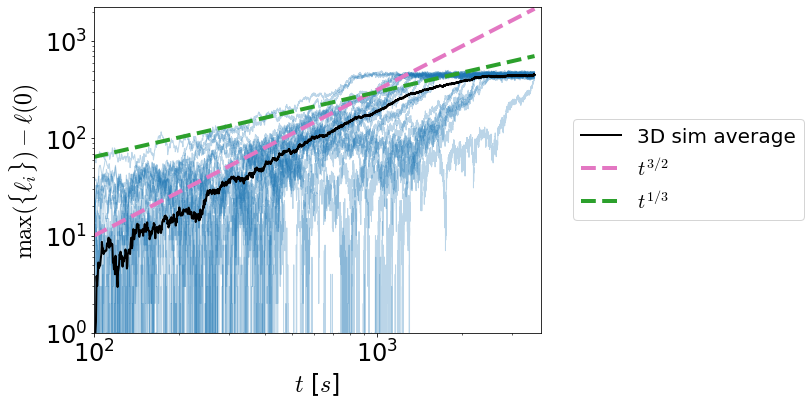

In [ ]:

fig, axarr = plt.subplots(1,1, figsize=(8,6), sharey=True, sharex=True)
plot_params = {"linewidth": 1, "markersize": .5, "marker":'', "alpha":0.3, "linestyle":'-'}

cluster_size_list = []
largest_time_arr = []
with h5py.File("Figure4/fig4_cluster_data.h5", 'r') as h5_graph:
    for name, d_set in h5_graph['dissolve'].items():
        try:
            clust_arr = d_set[:,1][::-1]
            condition = clust_arr > 40

            time_arr = d_set[condition,0][::-1]
            clust_arr = clust_arr[condition]
            if min(clust_arr) > 100: # Look for clusters that have not dissolved
                last_time_step = max(time_arr)
                if len(largest_time_arr) < len(time_arr):
                    print(len(time_arr))
                    largest_time_arr = time_arr
                # _ = axarr.plot(time_arr-last_time_step , clust_arr, color='tab:blue', **plot_params)
                # _ = axarr.plot(time_arr[200:], clust_arr[200:]-clust_arr[200], color='tab:blue', **plot_params)
                _ = axarr.plot(time_arr, clust_arr-clust_arr[0], color='tab:blue', **plot_params)
                cluster_size_list += [clust_arr]
        except:
            print("Error")
            print(name)
            print(d_set[:,1])
            print(d_set[:,0])
            pass
            

mean_size_arr = mean_of_arrays(cluster_size_list)
last_time_step = max(largest_time_arr)
_ = axarr.plot(largest_time_arr, mean_size_arr-mean_size_arr[0], label="3D sim average", color='k')
_ = axarr.plot(largest_time_arr, .01*np.power(largest_time_arr, 3/2), label="$t^{3/2}$", color='tab:pink', linestyle='--', linewidth=4)
_ = axarr.plot(largest_time_arr, 3*np.power(largest_time_arr, 2/3), label="$t^{1/3}$", color='tab:green', linestyle='--', linewidth=4)
# _ = axarr.annotate("$t^{3/2}$", (1e3, 1e3), color='tab:pink')
# _ = axarr.annotate("$t^{2/3}$", (2e2, 2e2), color='tab:green')

_ = axarr.set_xlim(1e2)
_ = axarr.set_ylim(1)

_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))



_ = axarr.set_ylabel('$\max(\{\ell_i\})-\ell(0)$ ' )
_ = axarr.set_xlabel('$t$ [$s$]')
_ = axarr.set_xscale('log')
_ = axarr.set_yscale('log')



7201


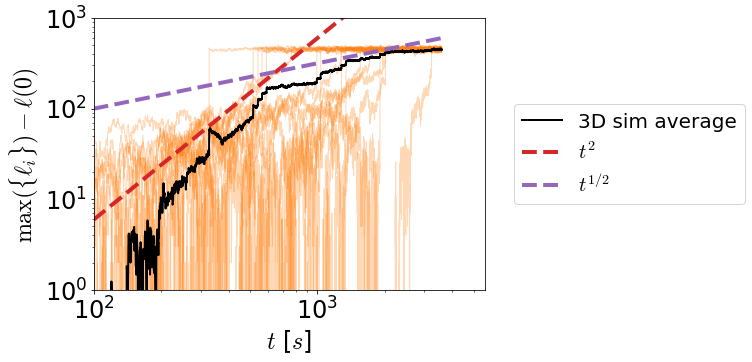

In [ ]:

fig, axarr = plt.subplots(1,1, figsize=(7,5), sharey=True, sharex=True)
plot_params = {"linewidth": 1, "markersize": .5, "marker":'', "alpha":0.3, "linestyle":'-'}

cluster_size_list = []
largest_time_arr = []
with h5py.File("Figure4/fig4_cluster_data.h5", 'r') as h5_graph:
    for name, d_set in h5_graph['merge'].items():
        try:
            clust_arr = d_set[:,1][::-1]
            condition = clust_arr > 40

            time_arr = d_set[condition,0][::-1]
            clust_arr = clust_arr[condition]
            if max(clust_arr) > 600: # Look for clusters that ar merged aftwards
                last_time_step = max(time_arr)
                if len(largest_time_arr) < len(time_arr):
                    print(len(time_arr))
                    largest_time_arr = time_arr
                # _ = axarr.plot(time_arr-last_time_step , clust_arr, color='tab:blue', **plot_params)
                _ = axarr.plot(time_arr, clust_arr-clust_arr[0], color='tab:orange', **plot_params)
                cluster_size_list += [clust_arr]
        except:
            print("Error")
            print(name)
            print(d_set[:,1])
            print(d_set[:,0])
            pass
            

mean_size_arr = mean_of_arrays(cluster_size_list)
last_time_step = max(largest_time_arr)
_ = axarr.plot(largest_time_arr, mean_size_arr-mean_size_arr[0], label="3D sim average", color='k')
_ = axarr.plot(largest_time_arr, .0006*np.power(largest_time_arr, 2), label="$t^{2}$", color='tab:red', linestyle='--', linewidth=4)
_ = axarr.plot(largest_time_arr, 10*np.power(largest_time_arr, 1/2), label="$t^{1/2}$", color='tab:purple', linestyle='--', linewidth=4)
# _ = axarr.annotate("$t^{3/2}$", (1e3, 1e3), color='tab:orange')

_ = axarr.set_xscale('log')
_ = axarr.set_yscale('log')

_ = axarr.set_xlim(1e2)
_ = axarr.set_ylim(1,1000)


_ = axarr.set_ylabel('$\max(\{\ell_i\})-\ell(0)$ ' )
_ = axarr.set_xlabel('$t$ [$s$]')
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))




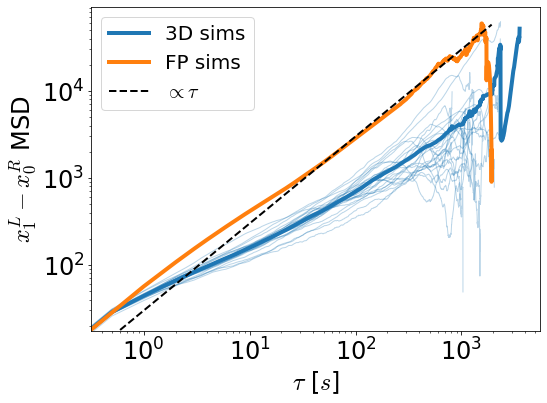

In [ ]:
plot_params = {"linewidth": 1, "markersize": .5, "marker":'', "alpha":0.3, "linestyle":'-'}
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

with h5py.File("Figure4/fig4_cluster_data.h5", 'r') as h5_graph:
    dissolve_grp = h5_graph['dissolve']

    msd_list = []
    time_arr_list = []
    max_time_arr = []
    for i in range(1, 49):
        if not f's{i}_0' in dissolve_grp: 
            continue

        sort_indices = np.argsort(dissolve_grp[f's{i}_0'][:,0])
        dset_0 = (dissolve_grp[f's{i}_0'][...])[sort_indices,:]

        sort_indices = np.argsort(dissolve_grp[f's{i}_1'][:,0])
        dset_1 = (dissolve_grp[f's{i}_1'][...])[sort_indices,:]

        time_arr = dset_0[:,0] if len(dset_0[:,0]) < len(dset_1[:,0]) else dset_1[:,0]
        dset_0 = dset_0[:len(time_arr)]
        dset_1 = dset_1[:len(time_arr)]

        if len(time_arr) > len(max_time_arr):
            max_time_arr = time_arr
        if dset_1[0,2] > dset_0[0,2]: # Cond 1 is to the right of cond 0
            xr = dset_0[:,2] + .5*dset_0[:,1]
            xl = dset_1[:,2] - .5*dset_1[:,1]
            edge_sep = xl - xr
        else:
            xl = dset_0[:,2] - .5*dset_0[:,1]
            xr = dset_1[:,2] + .5*dset_1[:,1]
            edge_sep = xl - xr
            
        msd_list.append(condensate_msd(edge_sep[np.newaxis,:].astype('float'), device=device).cpu()[0])
        _ = axarr.plot(time_arr, msd_list[-1], color='tab:blue', **plot_params)
        # msd_list[-1].shape
        # time_arr_list.append(time_arr)

    avg_size_arr = mean_of_arrays(msd_list)
    _ = axarr.loglog(max_time_arr, avg_size_arr, color='C0', linewidth=4, label="3D sims")
    # _ = axarr.loglog(max_time_arr, 30*max_time_arr, color='k', linewidth=2, linestyle='--', label)



data_path =  next(ceph_path.glob('DynCondPaper/minimal_cond_runs/24-03-21_Renger1600_slice9.7.1_sep50-450_L3-9um/simulations/lsep100_L5/*.h5'))
with h5py.File(data_path, 'r') as h5_data:
    params = yaml.safe_load(h5_data.attrs['params'])

    nu = params['kinetics']['nu']
    gamma = params['kinetics']['gamma']
    alpha = params['kinetics']['alpha']
    kappa = params['kinetics']['kappa']
    L = params['kinetics']['L']
    b = params['kinetics']['bd']
    Lc = params['n_beads'] * b
    beta = 1./.00411
    # t_max = params['t_max']
    ko = 15

    time_arr_list = []
    com_arr_list = []
    size_arr_list = []

    edge_diff_msd_list = []
    time_arr_list = []
    max_time_arr = np.array([])
    for group in h5_data.keys():
        if 'run' not in group:
            continue
        group_data = h5_data[group]

        last_sizes = group_data['sizes'][0, -1]
        if not(last_sizes[0] == 0 or last_sizes[1] == 0):
            continue
        time_arr = group_data['times'][...]

        state_arr = group_data['states'][...]
        l_diff = state_arr[:,1,0] - state_arr[:,0,1] 
        reg_time_arr, reg_l_diff = calc_regular_interval_kmc_array(time_arr, l_diff, time_arr[-1], 15)
        if len(reg_time_arr) > len(max_time_arr):
            max_time_arr = reg_time_arr
        edge_diff_msd_list.append(condensate_msd(reg_l_diff[np.newaxis,:].astype('float'), device=device).cpu()[0])
        # _ = axarr.plot(reg_time_arr/ko, edge_diff_msd_list[-1], color='C0')
        time_arr_list.append(reg_time_arr)

    avg_size_arr = mean_of_arrays(edge_diff_msd_list)
    _ = axarr.loglog(max_time_arr/ko, avg_size_arr, color='C1', linewidth=4, label=r'FP sims')
    _ = axarr.loglog(max_time_arr/ko, 2*max_time_arr, color='k', linestyle='--', label=r'$\propto \tau$')


_ = axarr.set_xlabel(r'$\tau$ [$s$]')
_ = axarr.set_ylabel('$x^L_1 - x^R_0$ MSD') 
_ = axarr.legend()

fig.tight_layout()
fig.savefig("Figure4/edge_sep_msd.png", dpi=600,bbox_inches='tight')
        

Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees


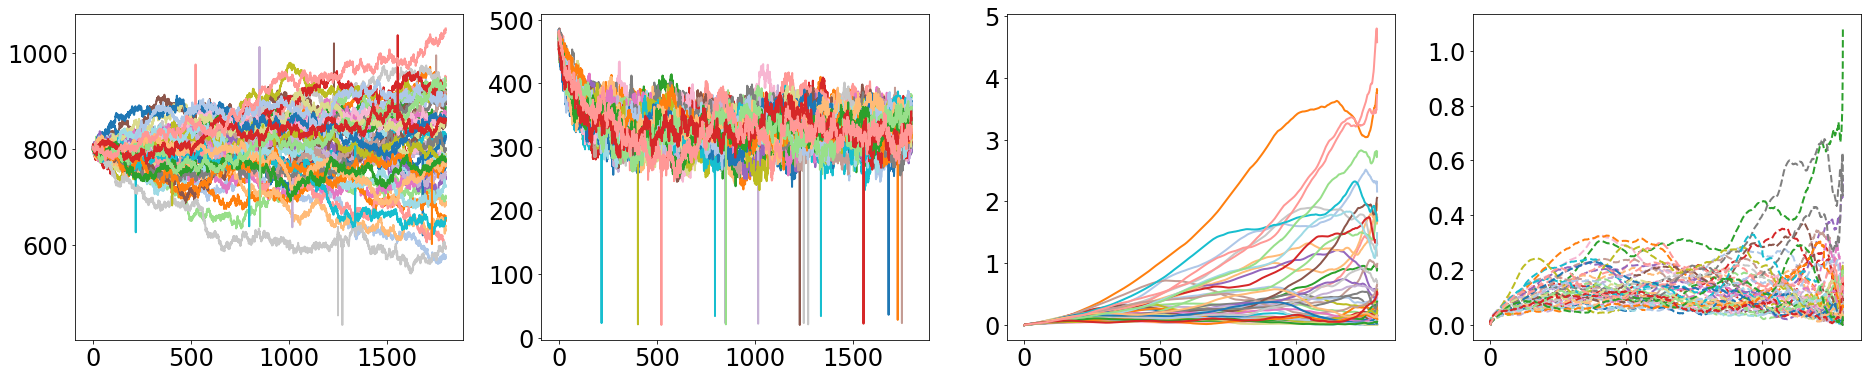

In [21]:
data_path = ceph_path / "DynCondPaper/24-05-02_aLc1_scan.48_line1600_Pin9um_2xKe30_ks100_1patch"
h5_list = list(data_path.glob('simulations/*/analysis/cluster_analysis.h5'))
large_tree_length = 100

tableau20_colors = iter(cycle(plt.cm.tab20.colors))
fig, axarr = plt.subplots(1,4, figsize=(32, 6), sharex=True)


com_msd_arr = []
len_msd_arr = []
com_arr_list = []
len_arr_list = []
for h5_cluster_file in h5_list:
    with h5py.File(h5_cluster_file, 'r') as h5_data:
        cluster_grp = h5_data['clusters']
        time_arr = h5_data['time'][...]
        time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
        clusters = []
        for tg in time_grp_list:
            clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]

    # Cluster tree
    root_clusters = cla.find_descendants(clusters, thresh=cluster_similarity_threshold, nskip=nskip)

    trees = []
    tree_id_gen = aa.helpers.gen_id()
    for root in root_clusters:
        tree = cla.ClusterTree(next(tree_id_gen))
        tree.add_recursive(root)
        trees += [tree]
    
    # Prune small trees
    trees = [tree for tree in trees if len(tree.clusters) > large_tree_length]

    print(f"Found {len(trees)} trees")
    if len(trees) != 1:
        print("Found multiple trees")
        continue


    # Graph all clusters
    for tree, color in zip(trees, tableau20_colors):
        clust_len_arr = []
        clust_com_arr = []
        time_arr = []
        # if len(tree.clusters) < large_tree_length:
        #     continue
        for clust in tree.clusters:
            clust_len_arr += [len(clust.part_ids)]
            clust_com_arr += [np.mean(clust.part_ids)]
            time_arr += [clust.time]
        
        # Sort arrays by time
        sort_indices = np.argsort(time_arr)
        clust_len_arr = np.array(clust_len_arr, dtype=float)[sort_indices]
        clust_com_arr = np.array(clust_com_arr)[sort_indices]
        time_arr = np.array(time_arr)[sort_indices]

        _ = axarr[0].plot(time_arr, clust_com_arr, c=color)
        _ = axarr[1].plot(time_arr, clust_len_arr, c=color)

        start_index = 1000

        com_msd = cluster_msd(clust_com_arr[start_index:], device=device)
        _ = axarr[2].plot(time_arr[:-start_index], com_msd*.01*.01, c=color)

        com_msd_arr.append(com_msd)
        com_arr_list.append(clust_com_arr)

        len_msd = cluster_msd(clust_len_arr[start_index:], device=device)
        _ = axarr[3].plot(time_arr[:-start_index], len_msd*.01*.01, c=color, linestyle='--')


        len_msd_arr.append(len_msd)
        len_arr_list.append(clust_len_arr)
    
    axarr[0].set_ylabel('Cluster center $c_i$')
    axarr[1].set_ylabel('Cluster size $\ell_i$')
    axarr[2].set_ylabel('Cluster center MSD')
    axarr[3].set_ylabel('Cluster size MSD')
    for ax in axarr:
        ax.set_xlabel('Time $t$ [$s$]')
    axarr[2].set_xscale('log')
    axarr[2].set_yscale('log')
    axarr[3].set_yscale('log')



In [22]:
# np.array(com_msd_arr).shape
# max_length = 2400-start_index 
msd_length = min([len(arr) for arr in com_msd_arr])
print(msd_length)
com_msd_list =[com_msd[:msd_length] for com_msd in com_msd_arr if len(com_msd) > msd_length]
len_msd_list = [len_msd[:msd_length] for len_msd in len_msd_arr if len(len_msd) > msd_length]
com_list =[com[:msd_length] for com in com_arr_list if len(com) > msd_length]
len_list = [leng[:msd_length] for leng in len_arr_list if len(leng) > msd_length]

with h5py.File("Figure4/fig4_single_cluster_data.h5", 'w') as h5_graph:
    h5_graph.attrs['data_dir'] = '24-05-02_aLc1_scan.48_line1600_Pin9um_2xKe30_ks100_1patch'
    h5_graph.attrs['start_ind'] = start_index
    time_dset = h5_graph.create_dataset('time', data=np.array(time_arr))
    com_msd_dset = h5_graph.create_dataset('com_msd', data=np.array(com_msd_list))
    len_msd_dset = h5_graph.create_dataset('len_msd', data=np.array(len_msd_list))
    com_arr_dset = h5_graph.create_dataset('com', data=np.array(com_list))
    len_arr_dset = h5_graph.create_dataset('len', data=np.array(len_list))




2601


1606
2158
4627
4665


/mnt/home/alamson/projects/analysis/aLENS_analysis/notebooks/chromatin_notebooks/Dyn_cond_figs/dyn_cond_fig_functions.py:295: RuntimeWarning: invalid value encountered in power
  2.0 * gamma * np.power(4.0 * np.pi * alpha * alpha / (3 * ld), 1.0 / 3.0)


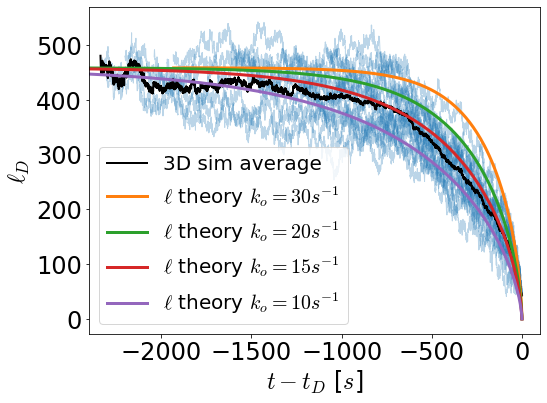

In [26]:
# def mean_of_arrays(arrays):
#     # Find the maximum length of the arrays
#     max_length = max(arr.shape[0] for arr in arrays)

#     # Create an array of np.nan values with shape (number of arrays, max length)
#     padded_arrays = np.full((len(arrays), max_length), np.nan)

#     # Replace the first n elements of each row with the values from the corresponding array
#     for i, arr in enumerate(arrays):
#         padded_arrays[i, :arr.shape[0]] = arr

#     # Compute the mean along the first axis, ignoring np.nan values
#     mean = np.nanmean(padded_arrays, axis=0)

#     return mean

fig, axarr = plt.subplots(1,1, figsize=(8,6), sharey=True, sharex=True)
plot_params = {"linewidth": 1, "markersize": .5, "marker":'', "alpha":0.3, "linestyle":'-'}

cluster_size_list = []
largest_time_arr = []
with h5py.File("Figure4/fig4_cluster_data.h5", 'r') as h5_graph:
    for name, d_set in h5_graph['dissolve'].items():
        try:
            clust_arr = d_set[:,1]
            condition = clust_arr > 40

            time_arr = d_set[condition,0]
            clust_arr = clust_arr[condition]
            if min(clust_arr) < 45:
                last_time_step = max(time_arr)
                if len(largest_time_arr) < len(time_arr):
                    print(len(time_arr))
                    largest_time_arr = time_arr
                _ = axarr.plot(time_arr-last_time_step , clust_arr, color='tab:blue', **plot_params)
                cluster_size_list += [clust_arr]
        except:
            print("Error")
            print(name)
            print(d_set[:,1])
            print(d_set[:,0])
            pass
            

mean_size_arr = mean_of_arrays(cluster_size_list)
last_time_step = max(largest_time_arr)
_ = axarr.plot(largest_time_arr-last_time_step, mean_size_arr, label="3D sim average", color='k')


_ = axarr.set_ylabel('$\ell_D$ ' )
_ = axarr.set_xlabel('$t - t_D$ [$s$]')


# Renger et al. parameters
tmax = 1e6
kappa = 0.0822
nu = 4.1
gamma = 0.15
alpha = 0.05
beta = 1.0 / 0.0041
b = 0.01
Lc = 16
L=5

max_ld = calc_max_length_in_two_condensates(L, Lc, nu, alpha, gamma, kappa)


sol = solve_ivp(
    two_cond_size_continuous_deriv,
    [0, tmax],
    [max_ld + 0.001, max_ld - 0.001],
    args=(nu, gamma, alpha, kappa, L, Lc, b, beta),
    dense_output=True,
)
_ = axarr.plot((sol.t-sol.t[-1])/30., sol.y[1]*100, color="C1", label="$\ell$ theory $k_o = 30 s^{-1}$", linestyle="-", linewidth=3)
_ = axarr.plot((sol.t-sol.t[-1])/20., sol.y[1]*100, color="C2", label="$\ell$ theory $k_o = 20 s^{-1}$", linestyle="-", linewidth=3)
_ = axarr.plot((sol.t-sol.t[-1])/15., sol.y[1]*100, color="C3", label="$\ell$ theory $k_o = 15 s^{-1}$", linestyle="-", linewidth=3)
_ = axarr.plot((sol.t-sol.t[-1])/10., sol.y[1]*100, color="C4", label="$\ell$ theory $k_o = 10 s^{-1}$", linestyle="-", linewidth=3)
_ = axarr.set_xlim(-2400, 100)

axarr.legend()

fig.tight_layout()
fig.savefig("Figure4/dissolve_event_sync.png", dpi=600,bbox_inches='tight')

# Collect data

In [9]:
data_path = ceph_path / "DynCondPaper/24-04-15_aLc1_scan.48_line1600_Pin5um_2xKe30_ks100_2patch_sep100_equil"
h5_list = list(data_path.glob('simulations/*/analysis/cluster_analysis.h5'))

print(len(h5_list))

large_tree_length = 240

merge_times = []
dissolve_times = [] 
nothing_events = 0

tableau10_colors = iter(cycle(plt.cm.tab10.colors))

n = 0
with h5py.File("Figure4/fig4_cluster_data.h5", 'w') as h5_graph:
    merge_grp = h5_graph.create_group(f'merge')
    dissolve_grp = h5_graph.create_group(f'dissolve') 
    nothing_grp = h5_graph.create_group(f'nothing') 
    for h5_file in h5_list:
        n += 1
        try:
            sd_num = h5_file.parent.parent.name
            print(sd_num)
            with h5py.File(h5_file, 'r') as h5_data:
                cluster_grp = h5_data['clusters']
                time_arr = h5_data['time'][...]
                last_time = time_arr[-1]
                time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
                clusters = []
                for tg in time_grp_list:
                    clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]
                    

            # Cluster tree
            root_clusters = cla.find_descendants(clusters, thresh=cluster_similarity_threshold, nskip=nskip)

            # The largest clusters at the start of the sim
            start_clusters = sorted(clusters[0], key=lambda x: len(x.part_ids), reverse=True)

            root0 = start_clusters[0].get_root()
            root1 = start_clusters[1].get_root()

            # If the two largest beginning clusters have the same root id at the end,
            # then this is a merging event

            if root0.id == root1.id:
                # Make the tree for these
                merge_tree = cla.ClusterTree(0) 
                merge_tree.add_recursive(root0)
                # Branch root with the largest mass history
                branch_root = sorted(merge_tree.get_branch_roots(), key=lambda x: x.mass_hist, reverse=True)[1]
                merge_times += [branch_root.time]
                print(f"{n} Merge event at time {branch_root.time}")

                l_branch = root0.get_largest_branch()
                data_arr = np.zeros((len(l_branch),3))
                for k, clust in enumerate(l_branch):
                    data_arr[k,0] = clust.time
                    data_arr[k,1] = len(clust.part_ids)
                    data_arr[k,2] = .5* (max(clust.part_ids) + min(clust.part_ids))
                merge_0_dset = merge_grp.create_dataset(f'{sd_num}_0', data=data_arr)
                
                sl_branch = branch_root.get_largest_branch()
                data_arr = np.zeros((len(sl_branch),3))
                for k, clust in enumerate(sl_branch):
                    data_arr[k,0] = clust.time
                    data_arr[k,1] = len(clust.part_ids)
                    data_arr[k,2] = .5* (max(clust.part_ids) + min(clust.part_ids))
                merge_1_dset = merge_grp.create_dataset(f'{sd_num}_1', data=data_arr)

                continue

            min_root_time = min(root0.time, root1.time)
            if min_root_time < last_time:
                dissolve_times += [min_root_time]
                print(f"{n} Dissolve event at time {min_root_time}")
                dissolve_tree = cla.ClusterTree(0) 
                dissolve_tree.add_recursive(root0)

                l_branch = root0.get_largest_branch()

                data_arr = np.zeros((len(l_branch),3))
                for k, clust in enumerate(l_branch):
                    data_arr[k,0] = clust.time
                    data_arr[k,1] = len(clust.part_ids)
                    data_arr[k,2] = .5* (max(clust.part_ids) + min(clust.part_ids))
                dissolve_0_dset = dissolve_grp.create_dataset(f'{sd_num}_0', data=data_arr)

                dissolve_tree_1 = cla.ClusterTree(1) 
                dissolve_tree_1.add_recursive(root1)
                l_branch = root1.get_largest_branch()
                data_arr = np.zeros((len(l_branch),3))
                for k, clust in enumerate(l_branch):
                    data_arr[k,0] = clust.time
                    data_arr[k,1] = len(clust.part_ids)
                    data_arr[k,2] = .5* (max(clust.part_ids) + min(clust.part_ids))
                dissolve_1_dset = dissolve_grp.create_dataset(f'{sd_num}_1', data=data_arr)

                continue
            
            nothing_events += 1
            print(f"{n} Nothing event")

            l_branch = root0.get_largest_branch()
            data_arr = np.zeros((len(l_branch),3))
            for k, clust in enumerate(l_branch):
                data_arr[k,0] = clust.time
                data_arr[k,1] = len(clust.part_ids)
                data_arr[k,2] = .5* (max(clust.part_ids) + min(clust.part_ids))
            dissolve_0_dset = nothing_grp.create_dataset(f'{sd_num}_0', data=data_arr)

            l_branch = root1.get_largest_branch()
            data_arr = np.zeros((len(l_branch),3))
            for k, clust in enumerate(l_branch):
                data_arr[k,0] = clust.time
                data_arr[k,1] = len(clust.part_ids)
                data_arr[k,2] = .5* (max(clust.part_ids) + min(clust.part_ids))
            dissolve_1_dset = nothing_grp.create_dataset(f'{sd_num}_1', data=data_arr)
        
            merge_grp.attrs['merge_times'] = merge_times
            dissolve_grp.attrs['dissolve_times'] = dissolve_times
            nothing_grp.attrs['nothing_events'] = nothing_events

        except:
            raise

48
s20
1 Merge event at time 1554.5
s11
2 Merge event at time 541.0
s18
3 Dissolve event at time 792.0
s12
4 Dissolve event at time 816.0
s31
5 Merge event at time 3242.5
s25
6 Nothing event
s5
7 Dissolve event at time 2183.5
s9
8 Merge event at time 1727.5
s35
9 Dissolve event at time 2338.5
s39
10 Merge event at time 2015.0
s29
11 Dissolve event at time 1521.5
s32
12 Dissolve event at time 800.5
s19
13 Nothing event
s47
14 Nothing event
s15
15 Nothing event
s41
16 Dissolve event at time 1593.0
s43
17 Dissolve event at time 1935.5
s17
18 Dissolve event at time 1145.0
s8
19 Merge event at time 1966.0
s13
20 Dissolve event at time 1090.0
s34
21 Merge event at time 327.0
s7
22 Dissolve event at time 2201.5
s1
23 Merge event at time 1272.5
s36
24 Dissolve event at time 1061.0
s27
25 Merge event at time 515.0
s38
26 Merge event at time 564.5
s4
27 Merge event at time 1281.0
s26
28 Dissolve event at time 1312.5
s10
29 Dissolve event at time 1965.0
s42
30 Merge event at time 1032.5
s16
31 Di

# Supplemental figures

(0.0, 1600.0)

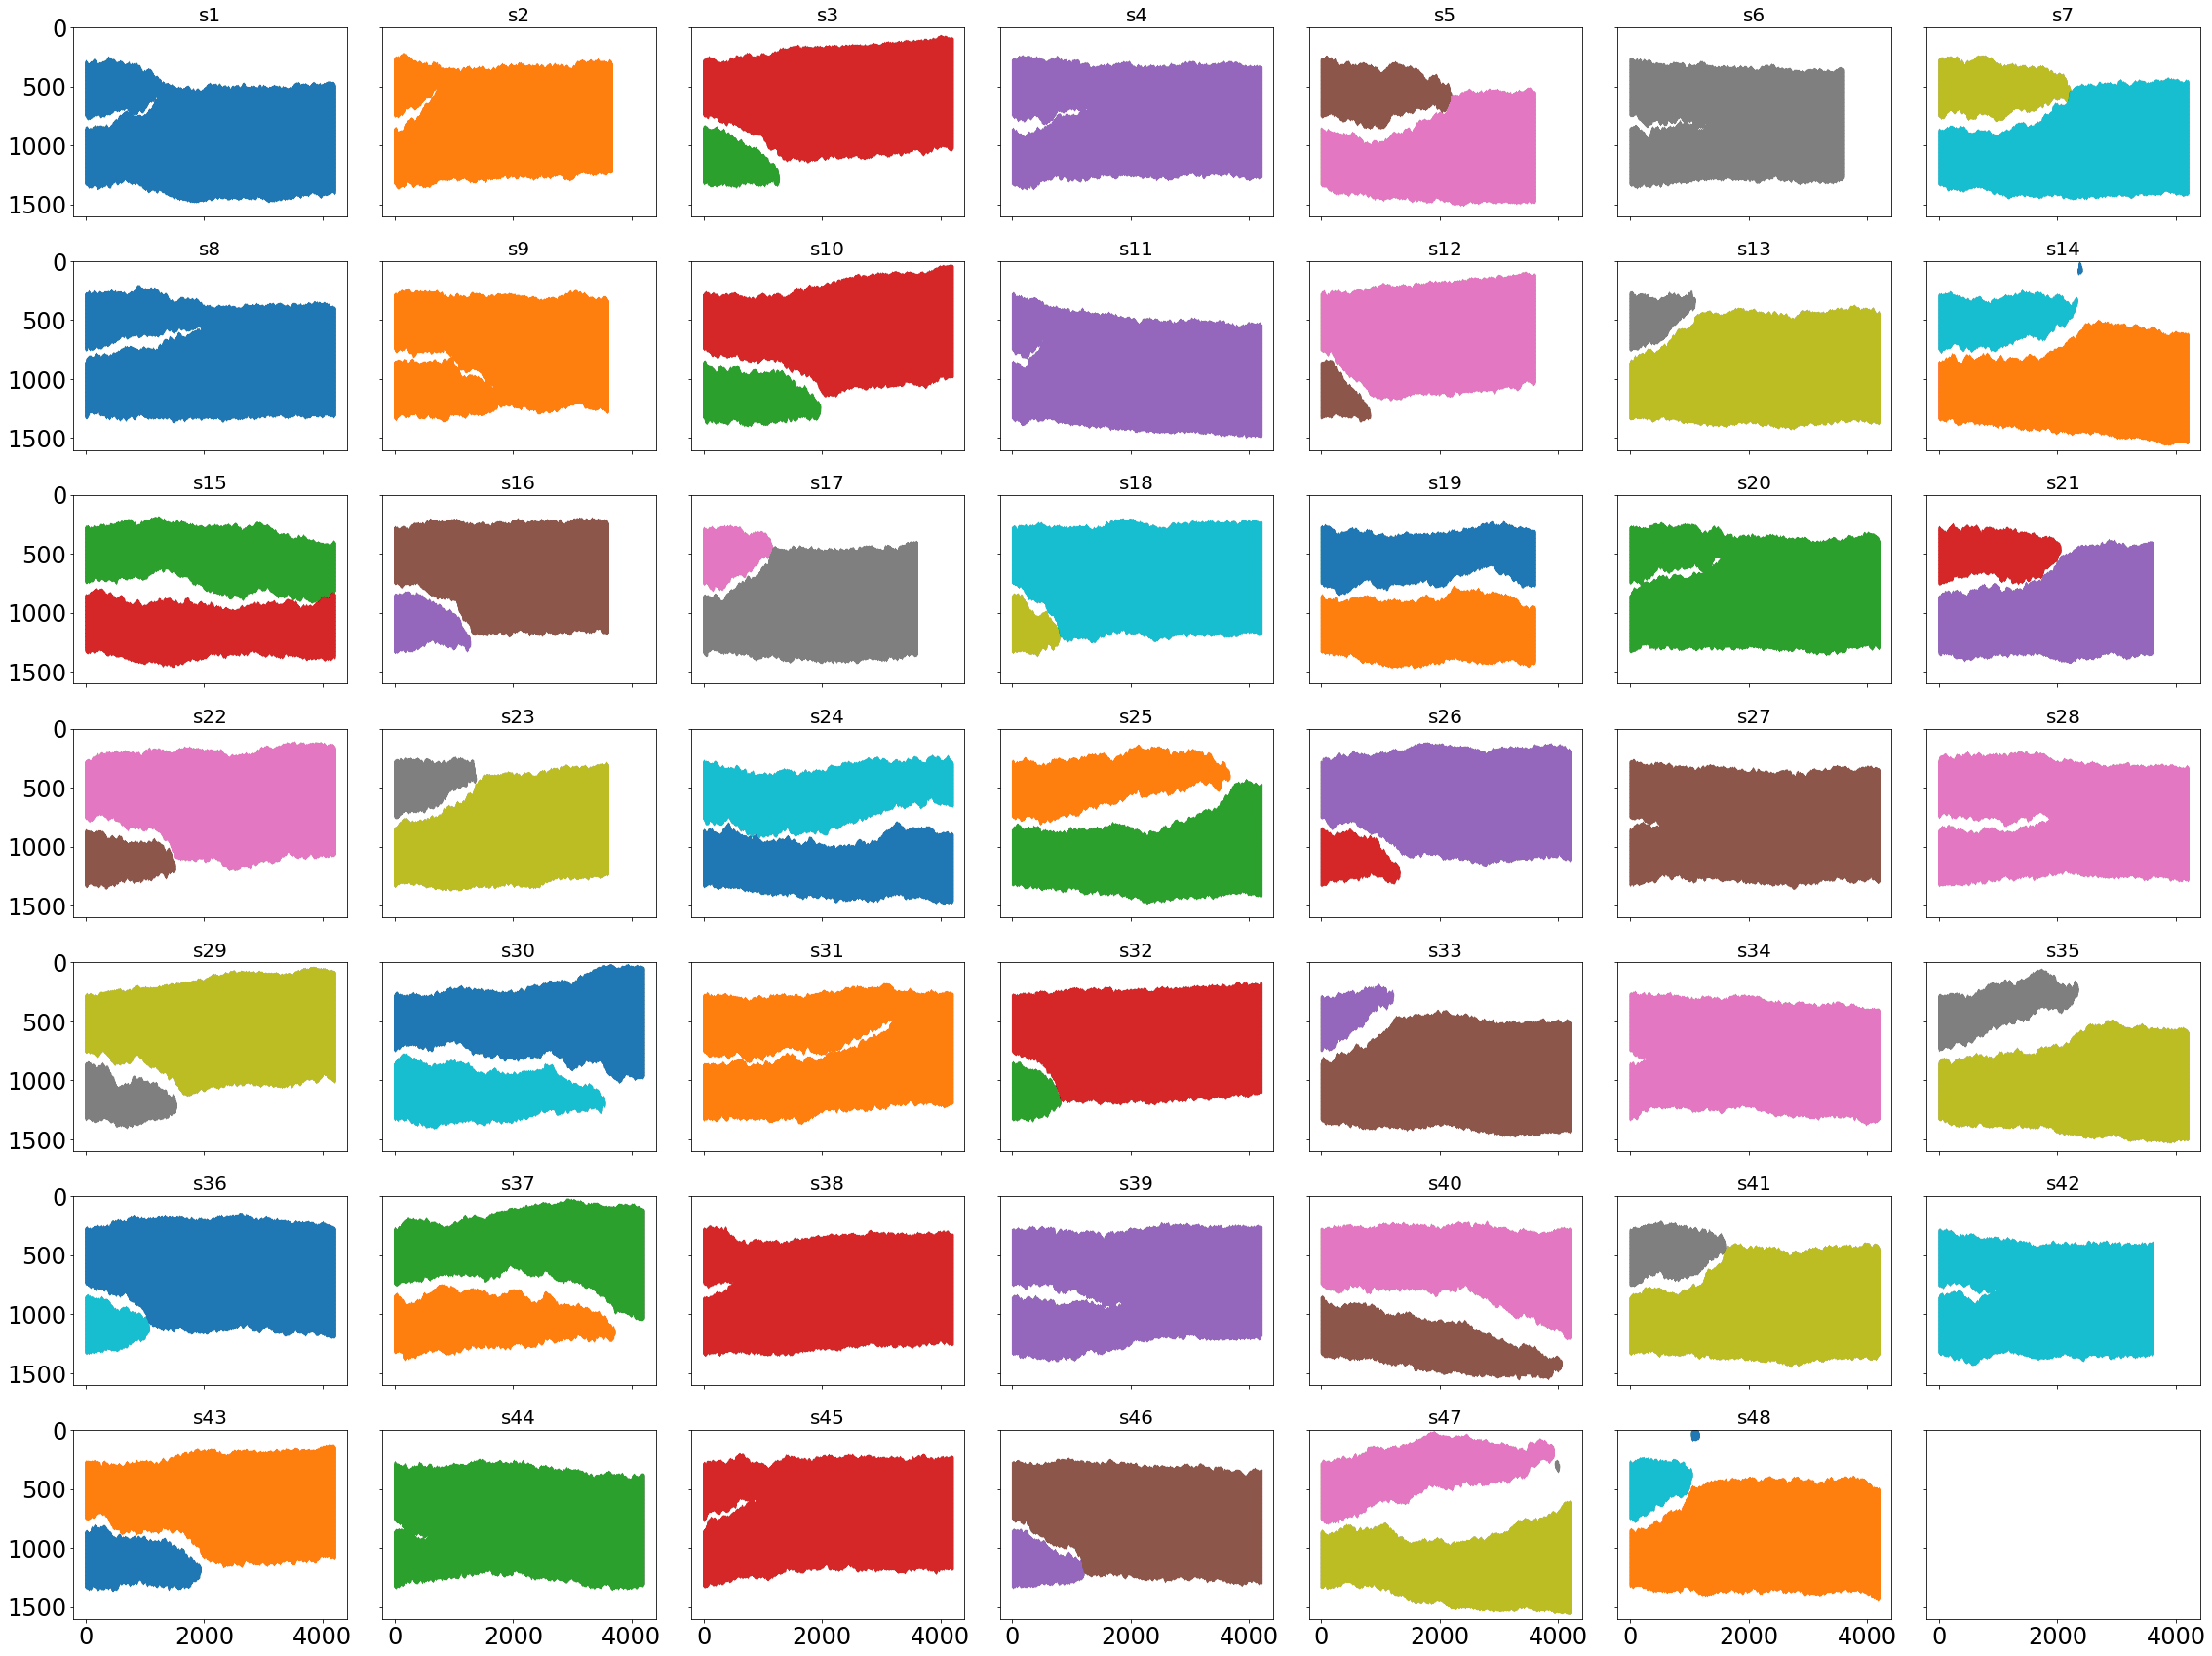

In [7]:
data_path = ceph_path / "DynCondPaper/24-04-15_aLc1_scan.48_line1600_Pin5um_2xKe30_ks100_2patch_sep100_equil"
h5_list = list(data_path.glob('simulations/*/analysis/cluster_analysis.h5'))

# sort h5_list by the parent parent directory name number that is s(number). Use regex to extract the number
h5_list = sorted(h5_list, key=lambda x: int(re.search(r'\d+', x.parent.parent.name).group()))



large_tree_length = 100

merge_events = 0
dissovle_events = 0
nothing_events = 0

tableau10_colors = iter(cycle(plt.cm.tab10.colors))

graph_side_length = int(np.ceil(np.sqrt(len(h5_list))))

fig, axarr = plt.subplots(graph_side_length, graph_side_length, figsize=(32, 24), sharex=True, sharey=True)

for i in range(graph_side_length):
    for j in range(graph_side_length):
        if i*graph_side_length + j >= len(h5_list):
            break
        try: 
            with h5py.File(h5_list[i*graph_side_length+j], 'r') as h5_data:
                cluster_grp = h5_data['clusters']
                time_arr = h5_data['time'][...]
                time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
                clusters = []
                for tg in time_grp_list:
                    clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]

            # Cluster tree
            root_clusters = cla.find_descendants(clusters, thresh=cluster_similarity_threshold, nskip=nskip)

            trees = []

            tree_id_gen = aa.helpers.gen_id()
            for root in root_clusters:
                tree = cla.ClusterTree(next(tree_id_gen))
                tree.add_recursive(root)
                trees += [tree]

            trees = [tree for tree in trees if len(tree.clusters) > large_tree_length]

            # Graph all clusters
            for tree in trees:
                color = next(tableau10_colors)
                for clust in tree.clusters:
                    _ = axarr[i,j].plot([clust.time]*len(clust.part_ids), clust.part_ids, color = color, markersize= .1, marker='.', linestyle='None')
            _ = axarr[i,j].set_title(h5_list[i*graph_side_length + j].parent.parent.name)
        except:
            raise

# axarr[0,0].set_xlim(0, 700)
axarr[0,0].set_ylim(0, 1600)
axarr[0,0].invert_yaxis()
fig.tight_layout()




Takes about 20 minutes to run analysis